In [1]:
import os
import glob
from pprint import pprint
import json
import pickle
from collections import OrderedDict
from Bio import SeqIO

In [2]:
from rdkit import Chem as chem
from rdkit.Chem import AllChem, Draw
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import imp
helper = imp.load_source('helper', './pks/helper.py')
domain = imp.load_source('domain', './pks/domain.py')
pks = imp.load_source('pks', './pks/pks.py')

In [4]:
file_path = './pks/split_files'
file_names = glob.glob(os.path.join(file_path, '*.embl'))

# Proccessing functions

In [5]:
def process_subunit_modules(sec_met): 
    '''This function takes as input the the list recorded by feature.qualifiers['sec_met'] for a module in a PKS
       cluster. This assumes that feature.type=='CDS' and that feature.qualifiers has the key 'sec_met'.
       The function returns a dict corresponding to the modules in the subunit, indexed starting from zero within
       the subunit. If the first entry of 'sec_met' is not 'Type: t1pks' then nothing is returned.
    '''
    # Initialize dict for the subunit
    subunit = {}
    orphan_subunit = {}   # this is for the NRPS/PKS domains that are not known catalytic domains
    
    # This is for the current module (function processes subunit which may have more than one module)
    module_index = 0  # key for module
    module_domains = [] # list of domains in module
    orphan_domains = [] # list of non-catalytic domains in module
    
    # This is how domains appear in sec_met:
    # ['PKS_AT', 'PKS_KS', 'PKS_KR', 'PKS_DH', 'PKS_ER', 'ACP', 'Thioesterase']
    # Iterate over the entries in sec_met
    for entry in sec_met:
        
        # Split entry into a list
        entrysplit = [item.strip() for item in entry.split(';') if item != '']
        # Check for catalytic domain
        domainsplit = entrysplit[0].split()
        
        if ' '.join(domainsplit[:2]) == 'NRPS/PKS Domain:' and len(domainsplit) > 2:
            # Note that we want to make sure that there is a leading 'PKS_' before we do our trimming
            # otherwise we just keep the entire annotation name, and save it under orphan_domains
            if domainsplit[2].split('_')[0] == 'PKS':
                if domainsplit[2] == 'PKS_Docking_Nterm':
                    domaintype = domainsplit[2]
                else:
                    # We trim off the leading 'PKS_'
                    # Assume DH2 and DHt are the same as DH 
                    domaintype = domainsplit[2].split('_')[-1].replace('DHt', 'DH').replace('DH2', 'DH')
            elif domainsplit[2] == 'CAL_domain':
                domaintype = 'CAL'
            else:
                domaintype = domainsplit[2]
        else:
            continue
        
        # Domain we want to recognize (we want to keep looking for PKS domains) but serve no 
        # catalytic function
        if domaintype in ['PKS_Docking_Nterm']:
            orphan_domains.append(' '.join(domainsplit))
        # Valid PKS catalytic domains
        elif domaintype not in ['KS', 'AT', 'KR', 'DH', 'ER', 'ACP', 'Thioesterase', 'cMT', 'CAL', 'PCP']:
            # Break out of for loop and stop looking for additional catalytic domains if we see a domain
            # that is not a valid PKS domain
            break
        boundaries = [int(bound) for bound in domainsplit[3].replace('(', '').replace(')', '').replace('.', '').split('-')]
        
        if domaintype in ['KS', 'DH', 'ER', 'ACP', 'cMT', 'CAL', 'PCP']:   # Recall that we trimmed leading 'PKS_'
            module_domains.append((domaintype, [{'start': boundaries[0], 'stop': boundaries[1]}]))
        # Include substrate and stereospecificity annotations for AT and KR domains respectively
        if domaintype in ['AT', 'KR']:   # Recall that we trimmed leading 'PKS_'
            notesdict = {}
            for note in entrysplit[1:]:
                item = note.split(': ')
                notesdict[item[0]] = item[1]
            module_domains.append((domaintype, [{'start': boundaries[0], 'stop': boundaries[1]}, notesdict]))
                
        # End of the module has been reached of the domain is 'ACP' or 'Thioesterase'
        # Implemented as a list in case we want to recognize PCP domains later on
        if domaintype in ['ACP', 'PCP']:
            domains_present = [d[0] for d in module_domains]
            # Make sure every module has an AT
            if 'AT' in domains_present:            
                subunit[module_index] = OrderedDict(module_domains)
                old_module_domains = module_domains
                # No need to do the whole "old_" copy because orphans we don't have to overwrite later
                orphan_subunit[module_index] = orphan_domains
                module_index += 1
            else:
                old_module_domains = []
            module_domains = []
            orphan_domains = []
        if domaintype == 'Thioesterase':
            # Overwrite previous subunit, or else will have duplicate entries
            old_module_domains.append((domaintype, [{'start': boundaries[0], 'stop': boundaries[1]}]))
            subunit[module_index - 1] = OrderedDict(old_module_domains)
            module_domains = []
            
    return (subunit, orphan_subunit)

In [6]:
# Recall:
# record = SeqIO.read(open(os.path.join(file_path, file_name), 'rb'), "embl")
# Possible keys (top end to be present, bottom tend to be optional):
# [product, codon_start, transl_table, translation, protein_id]
# [note, aSProdPred, sec_met, gene]

def add_description(base, addition):
    if base == '':
        return addition
    else:
        return base + '; ' + addition

def get_gene_data(record):
    '''Takes as input a record read in from an .embl file using SeqIO.read() and outputs PKS data 
       from that record. Data will be comprised of PKS subunits and standalone PKS genes.
    '''
    # Get list to hold information about all genes that are in the record
    gene_data = []
    
    # Only the "CDS" features are potentially genes
    for feature in record.features:
        if feature.type == 'CDS' and 'protein_id' in feature.qualifiers.keys() and 'gene' in feature.qualifiers.keys():
            # This gets the location of the feature
            location = feature.location
            # General information about gene
            description = ''
            if 'product' in feature.qualifiers.keys():
                description += feature.qualifiers['product'][0]
            if 'note' in feature.qualifiers.keys():
                description = add_description(description, feature.qualifiers['note'][0])
            gene_data.append([feature.qualifiers['protein_id'][0],
                              feature.qualifiers['gene'][0],
                             ])
            
            # Need in case feature does no thave subunits
            subunit_modules = None
            # Information if gene is PKS subunit
            # NOTE THAT THIS RESULTS IN ITERATIVE SUBUNITS BEING PROCESSED AS STANDALONES
            if 'sec_met' in feature.qualifiers.keys() and len(feature.qualifiers['sec_met']) > 3:
                if feature.qualifiers['sec_met'][3] in ['NRPS/PKS subtype: Type I Modular PKS', 
                                                        'NRPS/PKS subtype: PKS-like protein',
                                                        'NRPS/PKS subtype: PKS/NRPS-like protein']:    
                    # Note that now we also keep orphan modules
                    # which are those that we don't explicitly recognize as catalytic domains
                    subunit_modules, orphan_modules = process_subunit_modules(feature.qualifiers['sec_met'])

            if description == '':
                description = 'No product description available'
            # More general information
            gene_data[-1].extend([description, [location.start.position, location.end.position]])

            # Subunit information
            if subunit_modules:
                gene_data[-1].append(subunit_modules)
                gene_data[-1].append(orphan_modules)

            # General information about gene
            gene_data[-1].append(feature.qualifiers['translation'][0])

    return gene_data

In [7]:
def process_cluster(record):
    '''Takes in a record and then returns pks.Cluster object representing the cluster.
    '''
    gene_data = get_gene_data(record)
    
    # Initalize lists for standalones and subunits
    unordered_subunits = {}
    standalones = []
    
    # Recall that each entry in gene_data is a list
    # [protein id, gene, product, [location start, location end], OPTIONAL SUBUNIT DICT, translation]
    for gene in gene_data:
        geneid = gene[0]
        genename = gene[1]
        genedesc = gene[2]
        genestart = gene[3][0]
        genestop = gene[3][1]
        genetranslation = gene[-1]
        # Just use length of gene_data to differentiate between standalones and subunits
        if len(gene) == 7:
            # Get subunit data from gene
            genesubunitdata = gene[-3]
            unordered_subunits[genename] = (geneid, genedesc, genestart, genestop,
                                            # The gene[-2] is the orphan data
                                            genesubunitdata, gene[-2], genetranslation)
        else:
            # Standalones lack subunit and orphan entries
            assert len(gene) == 5
            standalones.append(pks.Standalone(geneid, genename, genedesc, 
                                              genestart, genestop, genetranslation))

    # Note that all gene data has now been processed, want to reprocess to get right ordering 
    # Initialize final list of subunits
    subunits = []
    # Get ordered version of subunits
    ordered_subunits = list(unordered_subunits.keys())
    ordered_subunits.sort()
#    print ordered_subunits
    modules_seen = 0
    for subunit in ordered_subunits:
        # subunit data has form (id, description, start, stop, module dict, sequence)
        subunitdata = unordered_subunits[subunit]
        # Initialize list to hold processed modules
        # this is a list of module objects that we will pass to pks.Subunit()
        modules = []
        # This is the modules for the subunit
        moduledata = subunitdata[-3]
        orphandata = subunitdata[-2]

        # We do this so we can lump in the loading didomain and TE on the first and last modules respectively
        modulekeys = list(moduledata.keys())
        
        imodule = 0
        while imodule < len(modulekeys):
            # Get info
            keys = list(moduledata[modulekeys[imodule]].keys())
            values = moduledata[modulekeys[imodule]].values()
            # Process info according to loading or not
            if modules_seen == 0:
                loading = True
#                 if len(modulekeys) > 1:
#                     moduledict = OrderedDict([(k+'L',v) \
#                                               if k == "AT" \
#                                               else (k,v) \
#                                               for k,v in moduledata[modulekeys[imodule]].items()] + 
#                                              [(k,v) for k,v in moduledata[modulekeys[imodule+1]].items()])
#                     # At this point hte orphan data is just lists
#                     orphandict = orphandata[modulekeys[imodule]] + orphandata[modulekeys[imodule+1]]
#                     imodule += 1
#                 else:
                
                moduledict =  OrderedDict([(k.replace('KS', 'KSQ').replace('AT', 'ATL'),v) \
                                          if k in ['KS','AT'] \
                                          else (k,v) \
                                          for k,v in zip(keys,values)])
                orphandict = orphandata[modulekeys[imodule]]
            else: 
                loading = False
                moduledict = OrderedDict([(k,v) for k,v in zip(keys,values)])
                orphandict = orphandata[modulekeys[imodule]]
            # Determine whether module is terminal or not
            if 'Thioesterase' in list(moduledata[modulekeys[imodule]].keys()):
                terminal = True
            else:
                terminal = False
            imodule += 1
            modules_seen += 1
            try:
                modules.append(pks.Module(moduledict, orphandict, loading=loading, terminal=terminal))
            # SUBUNITS CONTAINING AN INVALID MODULE ARE NOT ADDED
            except AssertionError as e:
                print(moduledict)
                print(orphandict)
                print(type(e).__name__, e.args, subunit + ' ' + subunitdata[1])
#                raise Exception(type(e).__name__, e.args, subunit + ' ' + subunitdata[1])
                break
        # Add subunit to list
        subunits.append(pks.Subunit(subunitdata[0], subunit, subunitdata[1],
                                    subunitdata[2], subunitdata[3], subunitdata[-1],
                                    modules))
            
    return (subunits, standalones)

# Process all clusters

In [8]:
import imp
helper = imp.load_source('helper', './pks/helper.py')
domain = imp.load_source('domain', './pks/domain.py')
pks = imp.load_source('pks', './pks/pks.py')

In [9]:
cluster_dict = {}

# Each file name corresponds to a cluster
for ifile_name, file_name in enumerate(file_names):
    record = SeqIO.read(file_name, "embl")
    
    cluster_id = record.id
    cluster_name = record.name
    cluster_description = record.description
    cluster_sequence = record.seq

    # Process cluster data into subunits and standalones"
#    print '(%d/%d)' %(ifile_name, len(file_names)), cluster_name, cluster_description
    subunits, standalones = process_cluster(record)
#    print '  ' + 'Subunits'
#     for subunit in subunits:
#         print '\t' + subunit.description
#         for module in subunit.modules:
#             print '\t' + str(module.domains.keys())
#             orphans = [entry.split()[2] for entry in module.orphans]
#             if len(orphans) > 0:
#                 print '\t' + str(orphans)
#     print '  ' + 'Standalones:'
#     for standalone in standalones:
#         print '\t' + standalone.description
    
    if len(subunits) == 0:
        continue 

    # Here is where we can implement our checks to see if our clusters are valid
    # TODO: What should we do with "invalid" subunits
    valid_subunits = []
    invalid_subunits = []
    add_cluster = True
    continue_adding = True
    
    for subunit in subunits:
        for module in subunit.modules:
            domains_present= module.domains.keys()
            if module.loading == True:
                if 'ATL' not in domains_present:
                    add_cluster = False
                    print('\t Rejecting cluster because lacking ATL.')
            else:
                if 'AT' not in domains_present:
                    print('\t Truncating at subunit with module lacking AT.')
                    print('\t' + subunit.name + ' ' + str(domains_present))
                    continue_adding = False
                if 'KS' not in domains_present or 'ACP' not in domains_present:
                    print('\t Truncating at module lacking KS.')
                    print('\t' + subunit.name + ' ' + str(domains_present))
                    continue_adding = False
        # Add subunit to appropriate list
        if continue_adding == True:
            valid_subunits.append(subunit)
        else:
            invalid_subunits.append(subunit)

    if add_cluster == True and len(valid_subunits) > 0:
        print('(%d/%d)' %(ifile_name, len(file_names)), cluster_name, cluster_description)
#        print('\t' + str([subunit.name for subunit in valid_subunits]))
#        print('\t' + str([subunit.name for subunit in invalid_subunits]))
#        print '\t' + str([standalone.name for standalone in standalones])
        cluster = pks.Cluster(cluster_id, cluster_name,
                              cluster_description, cluster_sequence,
                              valid_subunits, invalid_subunits, standalones)
        cluster_dict[cluster.id] = cluster

(2/217) AF263912 Streptomyces noursei ATCC 11455 nystatin biosynthetic gene cluster, complete sequence.
(8/217) AF497482 Micromonospora echinospora calicheamicin biosynthetic locus, complete sequence.
(9/217) EU035755 Streptomyces griseochromogenes tautomycetin biosynthetic gene cluster, complete sequence.
(11/217) AY179507 Streptomyces hygroscopicus strain NRRL 3602 geldanamycin biosynthesis gene cluster, partial sequence.
(18/217) AY310323 Streptomyces sp. FR-008 heptaene macrolide complex synthesis gene cluster, complete sequence.
(22/217) AF210249 Streptomyces verticillus bleomycin biosynthetic gene cluster, complete cds.
(28/217) AF333038 Streptomyces viridochromogenes Tue57 Avilamycin A biosynthetic gene cluster, complete sequence.
(30/217) AF082100 Streptomyces sp. MA6548 FK506 peptide synthetase (fkbP), FK506 oxidase (fkbO), and FK506 polyketide synthase (fkbB) genes, complete cds.
(36/217) JX545234 Streptomyces sp. K01-0509 guadinomine biosynthetic gene cluster, complete seque

In [10]:
# Use this to filter out clusters we don't want to deal with just yet
npks_clusters = 0
pruned_clusters = {}

# Get list of module names which are currently being ignored
orphanlist = []

for key,value in cluster_dict.items():
    cluster = value
    print(cluster.description)
    subunits = cluster.subunits
    if len(subunits) > 0:
        pruned_clusters[key] = value
        npks_clusters += 1
    for key,value in subunits.items():
        subunit = value
        modules = subunit.modules
        for module in modules:
#            pprint(module.orphans)
            orphanlist.extend([entry.split()[2] for entry in module.orphans])

print(npks_clusters)
print(set(orphanlist))

Streptomyces collinus kirromycin biosynthesis gene cluster, strain Tu 365.
Streptomyces venezuelae methymycin/pikromycin polyketide synthase gene cluster, complete sequence.
Polyangium cellulosum hypothetical protein gene, complete cds; chivosazol biosynthetic gene cluster, complete sequence; and hypothetical protein gene, complete cds.
Saccharopolyspora spinosa probable lysR-type transcriptional regulator, probable keto acyl reductase, spinosad biosynthetic gene cluster, complete sequence, and probable exodeoxyribonuclease V genes, complete cds; and unknown gene.
Aeromicrobium erythreum putative transcriptional repressor and putative dehydrogenase/reductase genes, complete cds; erythromycin biosynthesis gene cluster, complete sequence; putative oxidoreductase and LipN genes, complete cds; monoamine oxidase gene, partial cds; and unknown gene.
Streptomyces sahachiroi azinomycin B gene cluster, partial sequence.
Streptomyces verticillus bleomycin biosynthetic gene cluster, complete cds.

In [12]:
starter_units = []
extender_units = []
nmodules = 0
for key,value in pruned_clusters.items():
#    print key
    cluster = value
    print(cluster.description)
    subunits = cluster.subunits
    if len(subunits) == 0:
        print('ERROR NO SUBUNITS')
    for key,value in subunits.items():
        subunit = value
        print('\t' + subunit.description)
        for module in subunit.modules:
            print('\t' + str(module.operations))
            nmodules += 1
            if module.loading == True:
#                print '\t' + module.domains['ATL'][1]['Substrate specificity predictions']
                starter_units.append(module.domains['ATL'][1]['Substrate specificity predictions'].split()[0])
            else:
#                print '\t' + module.domains['AT'][1]['Substrate specificity predictions']
                extender_units.append(module.domains['AT'][1]['Substrate specificity predictions'].split()[0])
print(nmodules)

Streptomyces collinus kirromycin biosynthesis gene cluster, strain Tu 365.
	putative polyketide synthase; cis-AT polyketide synthase architecture
Stigmatella aurantiaca ORF8, ORF7, ORF6, ORF5, ORF4, ORF3, ORF2, ORF1, stiA gene, stiB gene, stiC gene, stiD gene, stiE gene, stiF gene, stiG gene, stiH gene, stiJ gene, stiK gene, stiL gene and ORF9.
	StiA protein
	StiB protein
	[<domain.KSAT object at 0x7f57f5a019b0>, <domain.KR object at 0x7f57f5a01a20>]
	StiC protein
	[<domain.KSAT object at 0x7f57f5a01b00>, <domain.KR object at 0x7f57f5a01c50>, <domain.DH object at 0x7f57f5a01c18>]
	StiF protein
	[<domain.KSAT object at 0x7f57f5a01e10>, <domain.KR object at 0x7f57f5a01dd8>, <domain.DH object at 0x7f57f5a01da0>, <domain.ER object at 0x7f57f5a01e48>]
	StiG protein
	[<domain.KSAT object at 0x7f57f5a01eb8>, <domain.DH object at 0x7f57f5a01f28>]
	StiH protein
	[<domain.KSAT object at 0x7f57f437f1d0>, <domain.KR object at 0x7f57f437fb70>]
	StiJ protein
Streptomyces venezuelae methymycin/pikrom

In [13]:
print(set(starter_units))
print(set(extender_units))

{'mmal', 'trans-1,2-CPDA', 'mal', 'isobut', 'mxmal', '2metbut', 'prop', 'CHC-CoA', 'N/A'}
{'mmal', 'emal', 'mal', 'mxmal'}


# Testing intermediate predictions

# Checking SCRATCH output

In [32]:
scratchdict = {}
extensions = ['fasta', 'ss', 'ss8', 'acc', 'acc20']
for iext,ext in enumerate(extensions):
    seq = None
    with open('./pks/160229_type1modular_subunits.' + ext, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if str(line)[0] == '>' and seq != None:
                key = line.split('|')[0][1:]
                try:
                    scratchdict[key][iext].append(seq)
                    seq = None
                except KeyError:
                    scratchdict[key] = [[seq], [], [], [], []]
                    seq = None
            else:
                if seq == None:
                    seq = line.strip()
                else:
                    seq += line.strip()

In [33]:
# See which of the clusters we already have Scratch information for
hasanalysis = []
noanalysis = []

accnums = list(scratchdict.keys())
for test_cluster in list(pruned_clusters.keys()):
    if test_cluster.split('.')[0] in set(accnums):
        hasanalysis.append(test_cluster)
    else:
        noanalysis.append(test_cluster)
print(hasanalysis)
print(noanalysis)

['AJ580915.1', 'AY271660.2', 'EU240558.1', 'AJ421825.1', 'AY947889.1', 'AF333038.2', 'AJ278573.1', 'AF357202.1', 'U24241.2', 'FJ483966.1', 'AY310323.2', 'AF016585.1', 'AJ575648.1', 'FJ952082.1', 'AF440781.1', 'AF453501.1', 'AB469193.1', 'AF263912.1', 'AB086653.1', 'AB435553.1', 'AY007564.1', 'AF521085.1', 'AY509120.1', 'AF497482.1', 'EF990140.1', 'AF079138.1', 'AJ871581.1', 'AY354515.1']
['JX545234.1', 'NC_005916.1', 'JF819834.1', 'FJ545274.1', 'FN547928.1', 'AF081920.3', 'AF217189.1', 'JN671974.1', 'EF140901.1', 'X86780.1', 'AM407731.1', 'AF235504.1', 'DQ885223.1', 'EF159954.1', 'AM746676.1', 'AM746336.1', 'AY623658.2', 'DQ176871.1', 'AF188287.1', 'FJ872525.1', 'FJ477836.2', 'FJ418586.4', 'HE616533.1', 'FJ872523.1', 'EU035755.1', 'AF220951.1', 'DQ897668.1', 'AF324838.2', 'HQ434551.1', 'AM988861.1', 'JF803645.1', 'AL123456.3', 'DQ065771.1', 'JQ793783.1', 'AY179507.1']


In [19]:
print(scratchdict.keys())
print(scratchdict['AF357202'])

dict_keys(['AY048670', 'AF333038', 'DQ149987', 'DQ354110', 'AJ871581', 'AF440781', 'AY509120', 'AJ575648', 'AB193609', 'AF263245', 'AY007564', 'AF357202', 'AJ421825', 'AF453501', 'AB303063', 'AB435553', 'AY947889', 'AF016585', 'AB241068', 'BX649209', 'AF040570', 'EU240558', 'HE586118', 'AY117439', 'AY442225', 'DQ914285', 'AY354515', 'AB568601', 'AY196994', 'AY271660', 'EF552206', 'FJ483966', 'DQ116941', 'HQ840721', 'AJ278573', 'AY310323', 'AB469193', 'AB086653', 'U24241', 'AF521085', 'FJ952082', 'AF497482', 'AF263912', 'AB032367', 'AB449340', 'AF079138', 'EF990140', 'AJ580915', 'DQ983361', 'AB070940'])
[['MTAEASQDKLRDYLRKTLADLRTTKQRLRDTERRATEPVAIVGMSCRLPGDVRTPERFWELLDTGTDALTPLPTDRGWNLDTAFDDERPYRREGGFLYDAGRFDAEFFGISPREALAMDPQQRLLLESSWEAIEHARIDPRSLHGSRTGVWFGTIGQDYFSLFAASGGEHANYLATACSASVMSGRVSYVLGLEGPAVTVDTACSSSLVALHSAVQALRSGECELALAGGATVMATPTVFTAFSHQRGLAGDGRCKAFAAGADGAGFAEGVGVLVLERLSVARRNGHRVLAVVRGSAVNQDGASNGLTAPNGPSQQRVIRAALANARLAPEDVDAVEGHGTGTSLGDPIEAQALLATYGRGRDAERPLWLGSVKSNIGHAQAAAGVA

In [38]:
matching = []
for cluster in hasanalysis:
    scratchkey = cluster.split('.')[0]   # get actual key
    subunits = pruned_clusters[cluster].subunits
    subunit_sequences = [subunit.sequence for subunit in list(subunits.values())]
    scratchseqs = scratchdict[scratchkey]
    missing = False
    for ss in subunit_sequences:
        if ss not in scratchseqs:
            missing = True
    if missing == False:
        print('%s missing subunit sequence!' %(cluster))
    else:
        print('%s CONTAINS subunit sequence!' %(cluster))
        matching.append(cluster)
print(len(matching))
print(matching)

AJ580915.1 CONTAINS subunit sequence!
AY271660.2 CONTAINS subunit sequence!
EU240558.1 CONTAINS subunit sequence!
AJ421825.1 CONTAINS subunit sequence!
AY947889.1 CONTAINS subunit sequence!
AF333038.2 CONTAINS subunit sequence!
AJ278573.1 CONTAINS subunit sequence!
AF357202.1 CONTAINS subunit sequence!
U24241.2 CONTAINS subunit sequence!
FJ483966.1 CONTAINS subunit sequence!
AY310323.2 CONTAINS subunit sequence!
AF016585.1 CONTAINS subunit sequence!
AJ575648.1 CONTAINS subunit sequence!
FJ952082.1 CONTAINS subunit sequence!
AF440781.1 CONTAINS subunit sequence!
AF453501.1 CONTAINS subunit sequence!
AB469193.1 CONTAINS subunit sequence!
AF263912.1 CONTAINS subunit sequence!
AB086653.1 CONTAINS subunit sequence!
AB435553.1 CONTAINS subunit sequence!
AY007564.1 CONTAINS subunit sequence!
AF521085.1 CONTAINS subunit sequence!
AY509120.1 CONTAINS subunit sequence!
AF497482.1 CONTAINS subunit sequence!
EF990140.1 CONTAINS subunit sequence!
AF079138.1 CONTAINS subunit sequence!
AJ871581.1 CON

In [50]:
# This dictionary will contain all fully complete clusters
complete_clusters = {}

# Recall that matching contains the labels for the clusters in pruned_clusters that also have 
# SCRATCH sequences in scratchdict
for key in matching:
#    print(key)
    value = pruned_clusters[cluster]
    scratchkey = key.split('.')[0]   # get key for scratchdict
#    print(scratchkey)
    scratchvalues = scratchdict[scratchkey]
    # Add the scratch values to subunit objects
    subunit_names = list(value.subunits.keys())    
    for i in range(len(value.subunits)):
        try:
            # It's fine if amino acid sequences don't match for now
#         assert scratchvalues[0][i] == value.subunits[subunit_names[i]].sequence
            value.subunits[subunit_names[i]].sspro = scratchvalues[1][i]
            value.subunits[subunit_names[i]].sspro8 = scratchvalues[2][i]
            value.subunits[subunit_names[i]].accpro = scratchvalues[3][i]
            value.subunits[subunit_names[i]].accpro20 = scratchvalues[4][i]
            complete_clusters[key] = value
        except IndexError:
            pass
            
# Pickle fully completely clusters as examples for Tyler
print(len(complete_clusters.keys()))
pickle.dump(complete_clusters, open('./complete_cluster_examples.p', 'wb'))

28


# Testing all clusters

In [ ]:
import imp
helper = imp.load_source('helper', './pks/helper.py')
domain = imp.load_source('domain', './pks/domain.py')
pks = imp.load_source('pks', './pks/pks.py')

In [20]:
for test_cluster in list(pruned_clusters.values()):
    name = test_cluster.name
    description = test_cluster.description
    dsplit = description.split()
    product = ''
    # Check for 'icin' or 'ycin' in name
    for item in dsplit:
        if 'icin' in item:
            product += item
        if 'ycin' in item:
            product += item
    # Check for a term that starts with 'bio' and take the preceding word
    if product == '':
        for iitem,item in enumerate(dsplit):
            if item[:3] == 'bio':
                product += dsplit[iitem-1]
    if product == '':
        product = description
            
    print('%s: %s' %(name, product))
    
    subunits = test_cluster.subunits
    if len(subunits) == 0:
        print('\t ERROR NO SUBUNITS')
    for key,value in subunits.items():
        subunit = value
        print('\t' + subunit.name)
        print('\t' + subunit.description)
        for module in subunit.modules:
            print('\t' + str(list(module.domains.keys())))
#            print('\t' + str(module.operations))

AM746336: kirromycin
	kirAVI
	putative polyketide synthase; cis-AT polyketide synthase architecture
	['KSQ', 'ATL', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'ACP']
AJ421825: Stigmatella aurantiaca ORF8, ORF7, ORF6, ORF5, ORF4, ORF3, ORF2, ORF1, stiA gene, stiB gene, stiC gene, stiD gene, stiE gene, stiF gene, stiG gene, stiH gene, stiJ gene, stiK gene, stiL gene and ORF9.
	stiA
	StiA protein
	['KSQ', 'ATL', 'DH', 'KR', 'ACP']
	stiB
	StiB protein
	['KS', 'AT', 'KR', 'ACP']
	stiC
	StiC protein
	['KS', 'AT', 'DH', 'KR', 'ACP']
	stiF
	StiF protein
	['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	stiG
	StiG protein
	['KS', 'AT', 'DH', 'ACP']
	stiH
	StiH protein
	['KS', 'AT', 'KR', 'ACP']
	stiJ
	StiJ protein
	['KS', 'AT', 'ACP']
AF079138: methymycin/pikromycin
	pikAI
	type I polyketide synthase PikAI; multifunctional polyketide synthase; contains a loading module, Pik module 1 and module 2
	['KSQ', 'ATL', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	['KS', 'AT', 'DH', 'KR', 'ACP']
	pikAII
	type I polyketide synt

JX545234
mal
gdnF
['KSQ', 'ATL', 'KR', 'ACP']
gdnG
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']


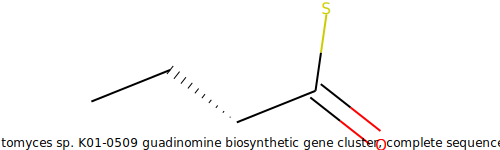

NC_005916
mal
mlsA1
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
mlsA2
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
mlsB
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


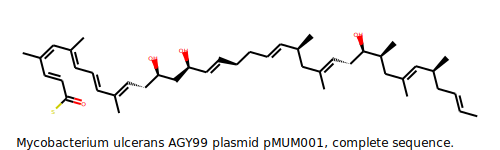

JF819834
mxmal
apoS1
['KSQ', 'ATL', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
apoS2
['KS', 'AT', 'DH', 'KR', 'ACP']
apoS5
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
apoS6
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
apoS7
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
apoS8
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


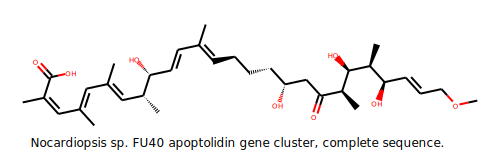

AJ580915
mal
borA2
['KSQ', 'ATL', 'KR', 'ACP']
borA3
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
borA4
['KS', 'AT', 'KR', 'ACP']
borA5
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
borA6
['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


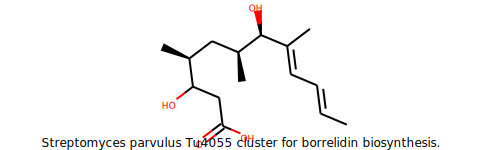

AY271660
mal
mdpB
['KSQ', 'ATL', 'DH', 'KR', 'ACP']


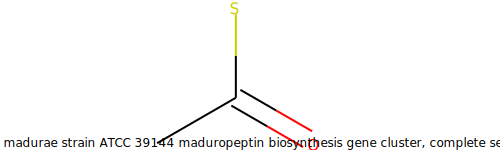

FJ545274
mal
idmL
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
idmM
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
idmN
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
idmO
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
idmP
['KS', 'AT', 'KR', 'ACP']


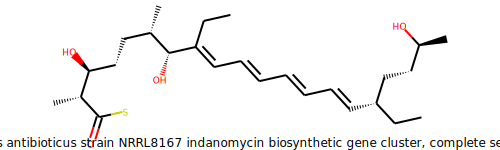

FN547928
mal
croC
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
croJ
['KS', 'AT', 'DH', 'KR', 'ACP']


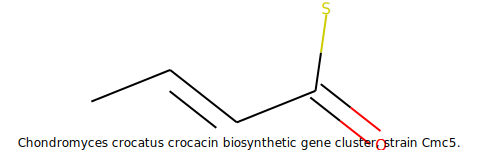

AF081920
mal
pltB
['KSQ', 'ATL', 'ACP']


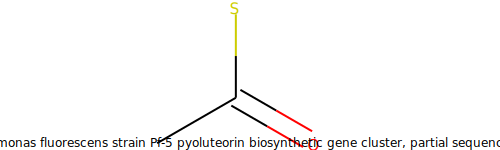

EU240558
mal
azi26
['KSQ', 'ATL', 'DH', 'KR', 'ACP']


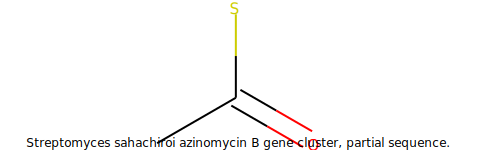

AJ421825
mmal
stiA
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
stiB
['KS', 'AT', 'KR', 'ACP']
stiC
['KS', 'AT', 'DH', 'KR', 'ACP']
stiF
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
stiG
['KS', 'AT', 'DH', 'ACP']
stiH
['KS', 'AT', 'KR', 'ACP']
stiJ
['KS', 'AT', 'ACP']


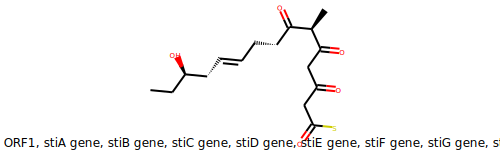

AY947889
mmal
hbmAII
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
hbmAIII
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


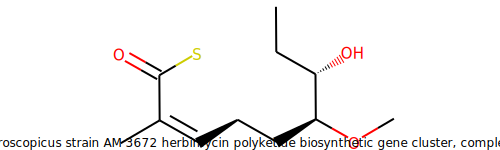

AF217189
mal
epoA
['KSQ', 'ATL', 'ER', 'ACP']
epoC
['KS', 'AT', 'DH', 'KR', 'ACP']
epoD
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
epoE
['KS', 'AT', 'KR', 'ACP']
epoF
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'Thioesterase']


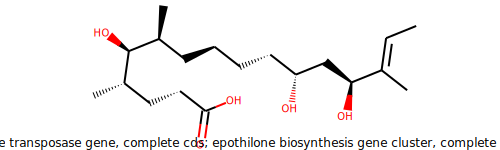

JN671974
mmal
herB
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
herC
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
herD
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


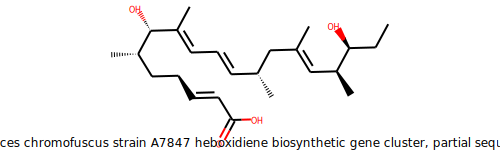

EF140901
mal
pyr24
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
pyr25
['KS', 'AT', 'ACP']


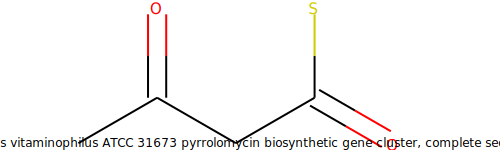

AF333038
mal
aviM
['KSQ', 'ATL', 'DH', 'ACP']


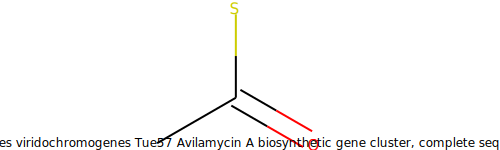

AJ278573
mal
pimS1
['KSQ', 'ATL', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
pimS2
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
pimS3
['KS', 'AT', 'DH', 'KR', 'ACP']
pimS4
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


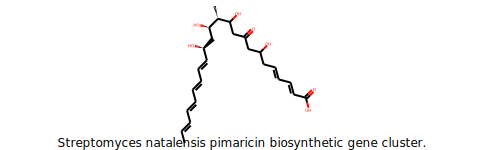

X86780
mal
rapB
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
rapC
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'ACP']


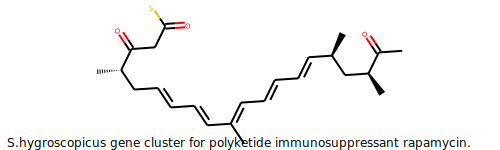

AM407731
mmal
spiD
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
spiE
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
spiF
['KS', 'AT', 'DH', 'KR', 'ACP']
spiG
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
spiH
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
spiI
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
spiJ
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


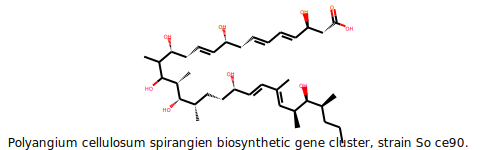

AF235504
mal
fkbA
['KSQ', 'ATL', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'ACP']
fkbC
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']


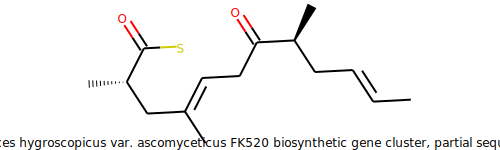

DQ885223
mal
merA
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
merB
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
merC
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


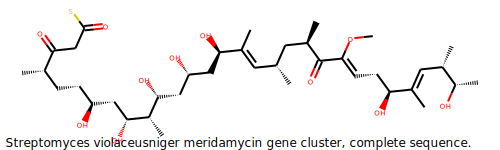

EF159954
mal
crpB
['KSQ', 'ATL', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


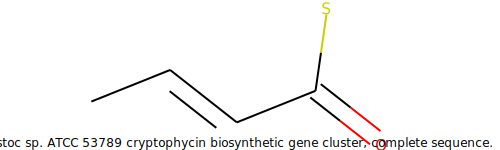

AM746676
mal
chiB
['KSQ', 'ATL', 'KR', 'ACP']


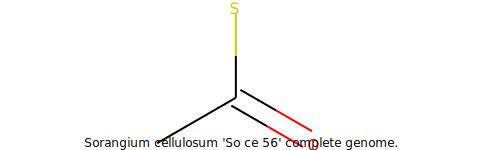

AM746336
mmal
kirAVI
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'ACP']


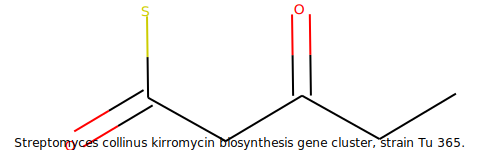

AF357202
mal
amphA
['KSQ', 'ATL', 'DH', 'ACP']
amphB
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
amphC
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
amphI
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
amphJ
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
amphK
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


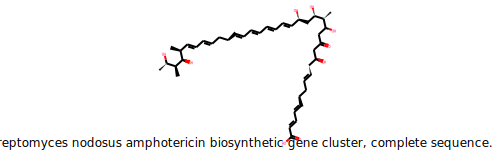

AY623658
prop
eryAI
['ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
eryAII
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
eryAIII
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


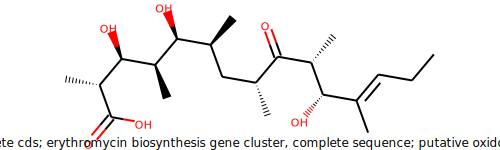

U24241
mal
sorA
['KSQ', 'ATL', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
sorB
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


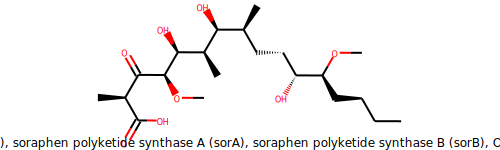

FJ483966
mmal
pokM1
['KSQ', 'ATL', 'KR', 'ACP']


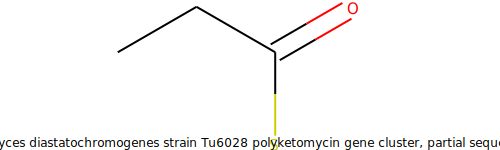

AY310323
mmal
fscB
['KSQ', 'ATL', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
fscC
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
fscD
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
fscE
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
fscF
['KS', 'AT', 'DH', 'KR', 'ACP']


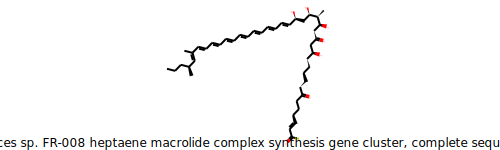

AF016585
mal
nidA1
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
nidA2
['KS', 'AT', 'DH', 'KR', 'ACP']
nidA3
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
nidA4
['KS', 'AT', 'KR', 'ACP']
nidA5
['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


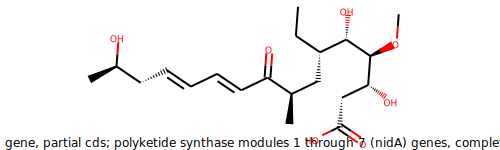

DQ176871
isobut
lipPks1
['ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
lipPks2
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
lipPks3
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
lipPks4
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'ACP']


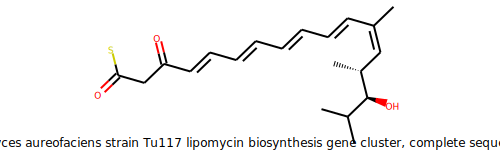

AJ575648
mmal
aurA
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
aurB
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']


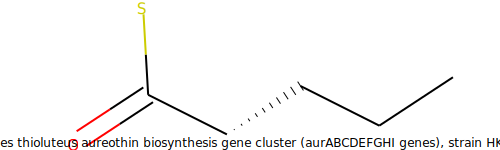

FJ952082
2metbut
meiA1
['ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
meiA2
['KS', 'AT', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
meiA3
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
meiA4
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


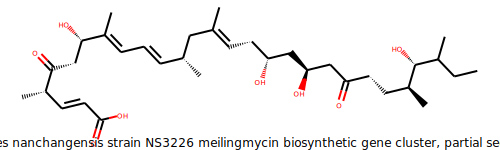

AF440781
mal
monAI
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
monAII
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
monAIII
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
monAIV
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
monAV
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
monAVI
['KS', 'AT', 'KR', 'ACP']
monAVII
['KS', 'AT', 'KR', 'ACP']
monAVIII
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


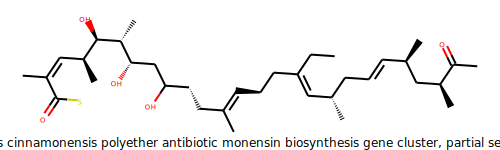

AF453501
mxmal
asmB
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'ACP']
asmC
['KS', 'AT', 'KR', 'ACP']
asmD
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


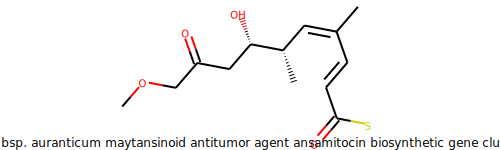

AF188287
mal
mtaB
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


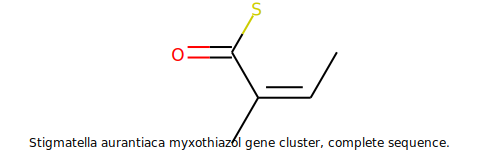

FJ872525
mmal
mlaA1
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
mlaB
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
mlaD
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
mlaE
['KS', 'AT', 'DH', 'KR', 'ACP']
mlaF
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
mlaG
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


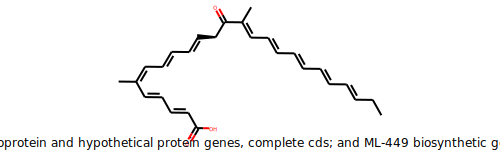

FJ477836
mal
anaE
['KSQ', 'ATL', 'DH', 'ER', 'KR', 'ACP']
anaF
['KS', 'AT', 'DH', 'KR', 'ACP']


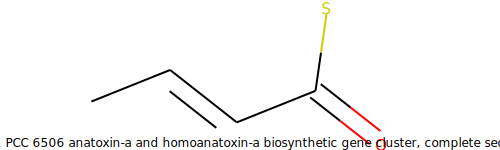

FJ418586
mal
cyrC
['KSQ', 'ATL', 'KR', 'ACP']
cyrD
['KS', 'AT', 'DH', 'KR', 'ACP']
cyrE
['KS', 'AT', 'DH', 'KR', 'ACP']
cyrF
['KS', 'AT', 'ACP']


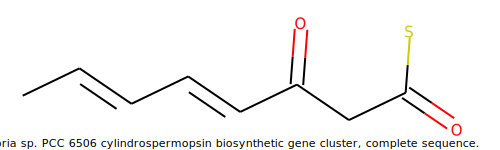

AB469193
mal
gfsA
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
gfsB
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
gfsC
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
gfsD
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
gfsE
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


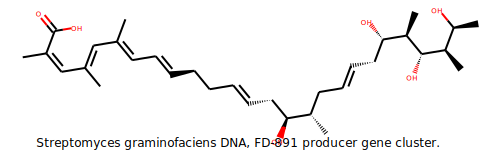

HE616533
mmal
pelB
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
pelC
['KS', 'AT', 'DH', 'KR', 'ACP']
pelD
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
pelE
['KS', 'AT', 'DH', 'KR', 'ACP']
pelF
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'Thioesterase']


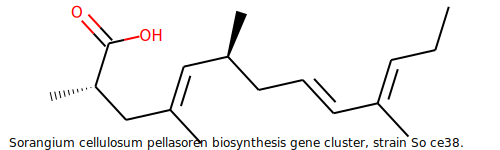

AF263912
mal
nysA
['KSQ', 'ATL', 'DH', 'ACP']
nysB
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
nysC
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
nysI
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
nysJ
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
nysK
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


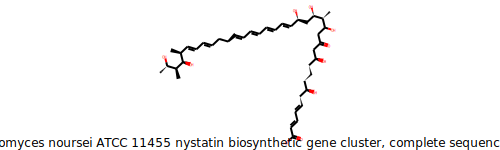

AB086653
mal
vinP1
['KSQ', 'ATL', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
vinP2
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
vinP3
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
vinP4
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


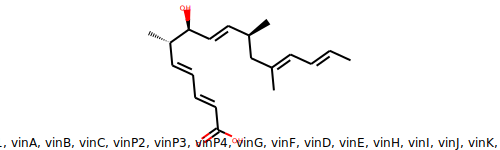

FJ872523
mmal
becA
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
becB
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
becD
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
becE
['KS', 'AT', 'DH', 'KR', 'ACP']
becF
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
becG
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


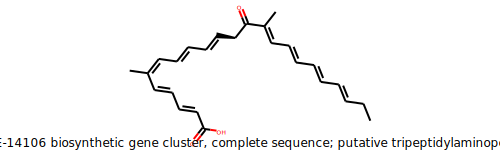

EU035755
mal
ttnA
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ttnB
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


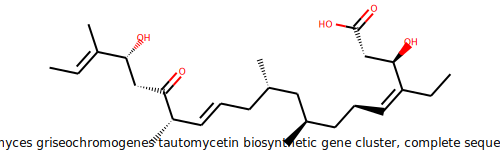

AB435553
mmal
pldAI
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
pldAII
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
pldAIII
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
pldAIV
['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


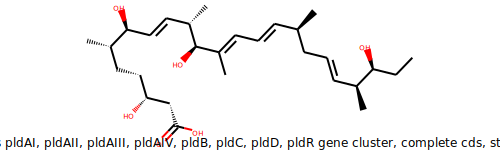

AY007564
mmal
spnA
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
spnB
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
spnC
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
spnD
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
spnE
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']


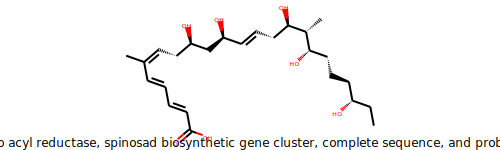

AF521085
mal
nanA1
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
nanA11
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
nanA2
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
nanA3
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
nanA4
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
nanA5
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
nanA6
['KS', 'AT', 'KR', 'ACP']
nanA7
['KS', 'AT', 'KR', 'ACP']
nanA8
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


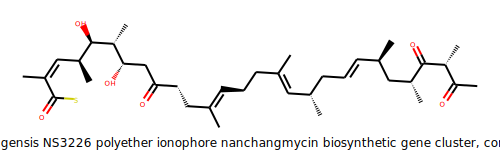

AF220951
mal
oleAI
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
oleAII
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']


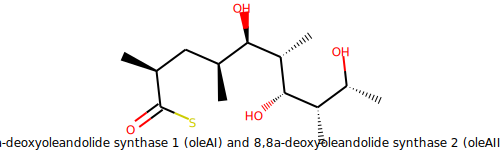

AY509120
mal
chmGI
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
chmGII
['KS', 'AT', 'DH', 'KR', 'ACP']
chmGIII
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
chmGIV
['KS', 'AT', 'KR', 'ACP']
chmGV
['KS', 'AT', 'ACP', 'Thioesterase']


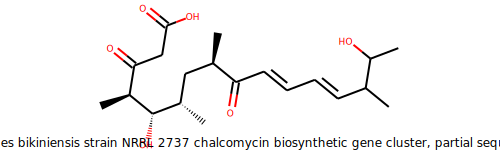

AF497482
mal
calO5
['KSQ', 'ATL', 'DH', 'ACP']


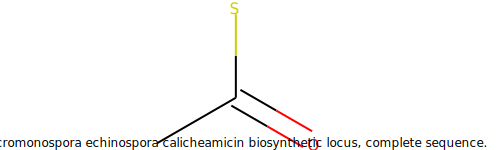

DQ897668
mmal
jerA
['KSQ', 'ATL', 'ACP']
jerB
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
jerC
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
jerD
['KS', 'AT', 'DH', 'KR', 'ACP']
jerE
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'ACP', 'Thioesterase']


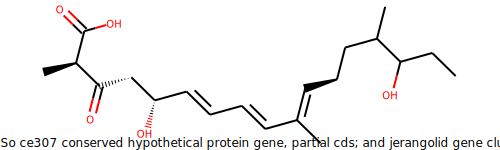

EF990140
mal
ttmH
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']
ttmI
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ttmJ
ERROR
AF079138
mmal
pikAI
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
pikAII
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
pikAIII
['KS', 'AT', 'KR', 'ACP']
pikAIV
['KS', 'AT', 'ACP', 'Thioesterase']


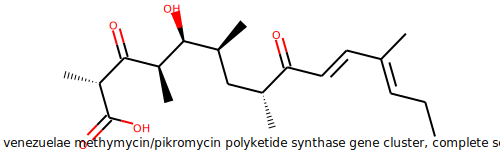

AF324838
mal
simC1A
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
simC1B
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
simC1C
['KS', 'AT', 'ACP', 'Thioesterase']


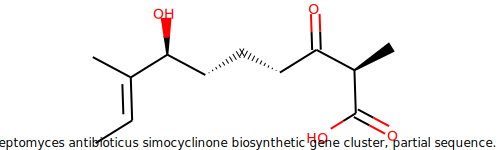

HQ434551
N/A
fosA
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
fosB
['KS', 'AT', 'DH', 'KR', 'ACP']
fosC
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
fosD
['KS', 'AT', 'DH', 'KR', 'ACP']
fosE
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
fosF
['KS', 'AT', 'KR', 'ACP', 'Thioesterase']
ERROR
AM988861
mmal
cndB
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
cndC
['KS', 'AT', 'DH', 'ACP']
cndD
['KS', 'AT', 'DH', 'KR', 'ACP']


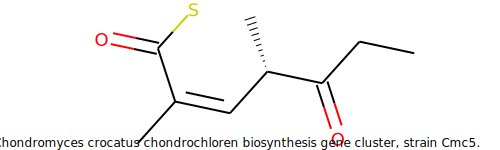

JF803645
mal
anaE
['KSQ', 'ATL', 'DH', 'ER', 'KR', 'ACP']
anaF
['KS', 'AT', 'DH', 'KR', 'ACP']


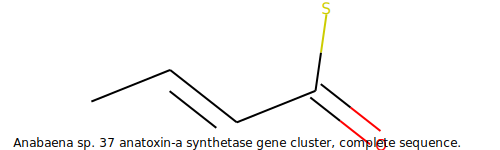

AL123456
mmal
mas
['KSQ', 'ATL', 'DH', 'ER', 'KR', 'ACP']
pks12
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
pks13
['KS', 'AT', 'ACP']
pks2
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
pks5
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
pks6
['KS', 'AT', 'ACP', 'Thioesterase']
pks7
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
pks9
['KS', 'AT', 'ACP']
ppsA
['KS', 'AT', 'DH', 'KR', 'ACP']
ppsB
['KS', 'AT', 'KR', 'ACP']
ppsC
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ppsD
['KS', 'AT', 'DH', 'KR', 'ACP']
ERROR
DQ065771
mal
chiB
['KSQ', 'ATL', 'KR', 'ACP']


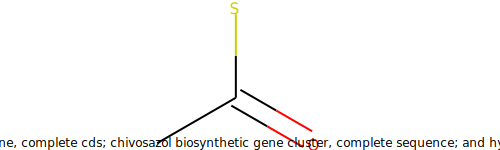

AJ871581
mmal
rubB
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


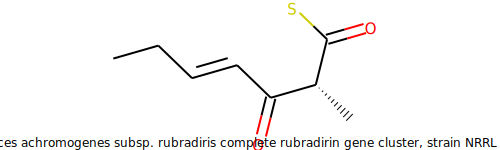

AY354515
CHC-CoA
plm1
['ATL', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']
plm2-3
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
plm4
['KS', 'AT', 'KR', 'ACP']
plm5
['KS', 'AT', 'DH', 'KR', 'ACP']
plm6
['KS', 'AT', 'KR', 'ACP']
plm7
['KS', 'AT', 'KR', 'ACP', 'Thioesterase']


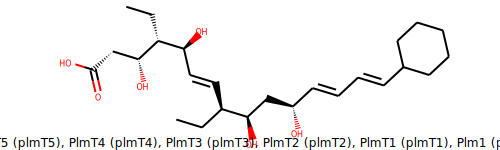

JQ793783
mal
ladSI
['KSQ', 'ATL', 'ACP']
['KS', 'AT', 'DH', 'ACP']
ladSII
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ladSIII
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ladSIV
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ladSV
['KS', 'AT', 'DH', 'KR', 'ACP']
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
ladSVI
['KS', 'AT', 'KR', 'ACP']
ladSVII
['KS', 'AT', 'KR', 'ACP']
ladSVIII
['KS', 'AT', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


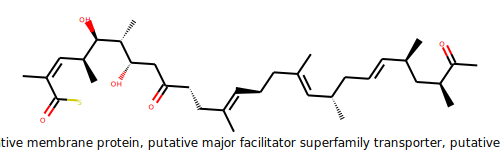

AY179507
mmal
gdmAII
['KSQ', 'ATL', 'DH', 'KR', 'ACP']
['KS', 'AT', 'KR', 'ACP']
gdmAIII
['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
['KS', 'AT', 'DH', 'KR', 'ACP']


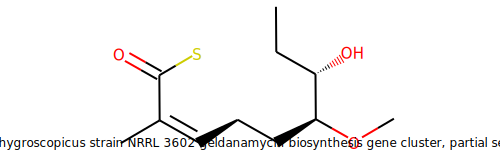

In [52]:
from IPython.display import display
from rdkit.Chem.Draw import IPythonConsole
valid = 0
for test_cluster in list(pruned_clusters.values()):
    try:
        print(test_cluster.name)
        print(list(test_cluster.subunits.values())[0].modules[0].operations[0].starter_name)
        subunits = list(test_cluster.subunits.values())
        for subunit in subunits:
            print(subunit.name)
            for module in subunit.modules:
                print(str(list(module.domains.keys())))
        m = test_cluster.compute_product(None)
        m_im = Draw.MolsToGridImage([m], legends=[test_cluster.description], 
                                    molsPerRow=1, subImgSize=(500,150), useSVG=True)
        display(m_im)
        valid += 1
    except Exception:
        print('ERROR')
    #plt.figure()
    #plt.imshow(np.asarray(m_im))
#     subunits = test_cluster.subunits
#     for subunit in subunits.values():      
#         for module in subunit.modules:
#             print(module.domains)
#             m = test_cluster.compute_product(m)
#             m_im = Draw.MolsToGridImage([m], molsPerRow=1, subImgSize=(200,200))
#             plt.figure()
#             plt.imshow(np.asarray(m_im))

In [53]:
print(valid)

60


mmal
KeysView(OrderedDict([('mas', <pks.Subunit object at 0x7f18bf2a8198>), ('pks12', <pks.Subunit object at 0x7f18bf756160>), ('pks13', <pks.Subunit object at 0x7f18bf756278>), ('pks2', <pks.Subunit object at 0x7f18bf756748>), ('pks5', <pks.Subunit object at 0x7f18bf7563c8>), ('pks6', <pks.Subunit object at 0x7f18bf28b550>), ('pks7', <pks.Subunit object at 0x7f18bf28b828>), ('pks9', <pks.Subunit object at 0x7f18bf28bda0>), ('ppsA', <pks.Subunit object at 0x7f18bf28b128>), ('ppsB', <pks.Subunit object at 0x7f18bf28bc50>), ('ppsC', <pks.Subunit object at 0x7f18beef9588>), ('ppsD', <pks.Subunit object at 0x7f18beef9a20>)]))


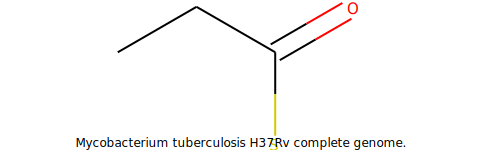

[<domain.KSAT object at 0x7f18bf2a8358>, <domain.KR object at 0x7f18bf2a8cc0>, <domain.DH object at 0x7f18bf2a80b8>, <domain.ER object at 0x7f18bf2a8c18>]


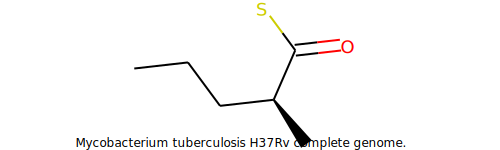

[<domain.KSAT object at 0x7f18bf756630>, <domain.KR object at 0x7f18bf7569e8>, <domain.DH object at 0x7f18bf756240>, <domain.ER object at 0x7f18bf756f28>]


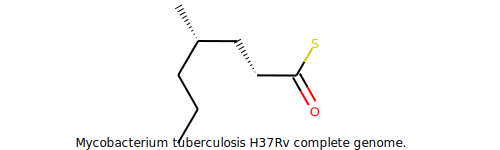

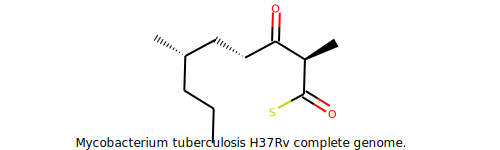

[<domain.KSAT object at 0x7f18bf756438>, <domain.KR object at 0x7f18bf756c50>, <domain.DH object at 0x7f18bf756dd8>, <domain.ER object at 0x7f18bf756780>]


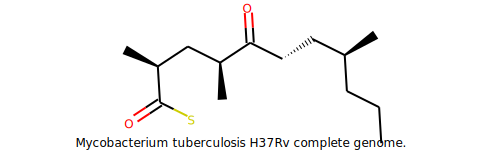

[<domain.KSAT object at 0x7f18bf756a90>, <domain.KR object at 0x7f18bf756ba8>, <domain.DH object at 0x7f18bf7568d0>, <domain.ER object at 0x7f18bf7567f0>]


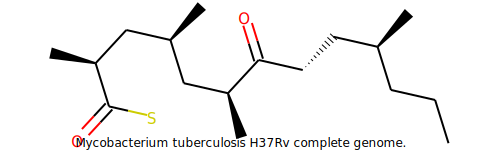

[<domain.KSAT object at 0x7f18bf28b6a0>, <domain.TE object at 0x7f18bf28bc18>]


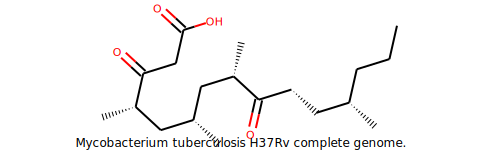

[<domain.KSAT object at 0x7f18bf28bef0>, <domain.KR object at 0x7f18bf28bac8>, <domain.DH object at 0x7f18bf28bcc0>, <domain.ER object at 0x7f18bf28b390>]


AssertionError: CCCC(C)CCC(=O)C(C)CC(C)CC(C)C(=O)CC(=O)O

In [54]:
test_cluster = pruned_clusters['AL123456.3']
print(list(test_cluster.subunits.values())[0].modules[0].operations[0].starter_name)
m = None
subunits = test_cluster.subunits
print(subunits.keys())
for subunit in list(subunits.values()):
    for module in subunit.modules:
        print(module.operations)
        m = module.compute_product(m)
        m_im = Draw.MolsToGridImage([m], legends=[test_cluster.description], 
                                    molsPerRow=1, subImgSize=(500,150), useSVG=True)
        display(m_im)